## 字段说明

| 字段 | 说明 |
| ---- | ---- |
| label | 0 唔開心，1 嬲，2 擔心，3 開心 |
| review | 數據内容 |

# Apply Model

# Fine tune

In [ ]:
!pip install transformers sentencepiece datasets
!pip install pytorch_lightning

from google.colab import drive
drive.mount('/content/gdrive/')

import os
os.chdir('/content/gdrive/MyDrive/Individual Project')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.7 MB 5.9 MB/s 
     |████████████████████████████████| 1.2 MB 45.9 MB/s 
     |████████████████████████████████| 365 kB 57.7 MB/s 
     |████████████████████████████████| 596 kB 8.2 MB/s 
     |████████████████████████████████| 101 kB 9.1 MB/s 
     |████████████████████████████████| 6.6 MB 19.3 MB/s 
     |████████████████████████████████| 212 kB 51.8 MB/s 
     |████████████████████████████████| 141 kB 51.9 MB/s 
     |████████████████████████████████| 127 kB 40.1 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
ERROR: pip's dependency resolver does not currently take into account all 

In [ ]:
#package imports 

import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F
import pytorch_lightning as pl

from transformers import DistilBertTokenizer, AutoTokenizer, AutoModelWithLMHead, DistilBertForSequenceClassification, AdamW, get_linear_schedule_with_warmup


from typing import List
import logging
import copy
import os
import sys
import gc
from functools import lru_cache
from argparse import Namespace
from packaging import version
from tqdm.autonotebook import tqdm

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

import pandas as pd
import numpy as np
from tqdm.auto import tqdm
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizerFast as BertTokenizer, BertModel, AdamW, get_linear_schedule_with_warmup
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, multilabel_confusion_matrix
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc

In [ ]:
#First, we finetune a T5 transformer model on the Emotion dataset (Saravia et al., 2018). This dataset contains
#labelled Twitter posts expressing one of the following emotions: fear, anger, joy, sadness, love, surprise.
#We will only use the emotions that we also have in our own dataset, namely fear, anger, joy, sadness.

import pickle

with open('/content/gdrive/MyDrive/Individual Project/Model/LargeDataset/merged_training.pkl', 'rb') as f:
    data = pickle.load(f)

In [ ]:
#drop rows classified as 'surprise' or 'love' which we don't need, we only want
#sadness, joy, anger and fear

data = data.loc[(data.emotions!='surprise') & (data.emotions!='love')]

label2int = {
  "sadness": 1,
  "joy": 2,
  "anger": 3,
  "fear": 4,
}

In [ ]:
#after the elimination we are left with 367,283 samples
len(data)

367283

In [ ]:
data = pd.read_csv('/content/gdrive/MyDrive/Individual Project/Model/LargeDataset/my_dataset.csv')

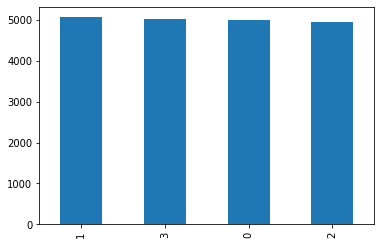

In [ ]:
#checking the label distribution reveals the dataset is unbalanced
data.label.value_counts().plot.bar()

In [ ]:
#we downsample the majority classes to match the minority class ('fear') and obtain a more equal split of emotion labels

#separate the majority and minority classes
df_minority  = data[data['emotions']=='fear']
df_majority1 = data[data['emotions']=='joy']
df_majority2 = data[data['emotions']=='sadness']
df_majority3 = data[data['emotions']=='anger']

#downsample majority labels equal to the number of samples in the minority class
df_majority1 = df_majority1.sample(len(df_minority), random_state=0)
df_majority2 = df_majority2.sample(len(df_minority), random_state=0)
df_majority3 = df_majority3.sample(len(df_minority), random_state=0)

#concat the majority and minority dataframes
df_new = pd.concat([df_majority1, df_majority2, df_majority3, df_minority])

#shuffle the dataset
df_new = df_new.sample(frac=1, random_state=0)

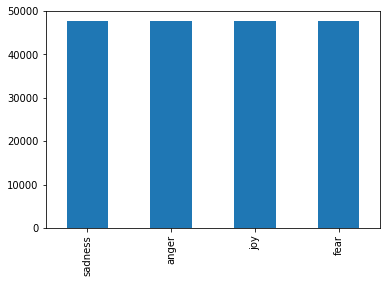

In [ ]:
#check the distribution again, now it's balanced
df_new.emotions.value_counts().plot.bar()

In [ ]:
#get subsample of 20k samples for fine tuning
data = df_new.sample(n=20000);

#reset index
data.reset_index(drop=True, inplace=True)

In [ ]:
#sanity check
len(data)

20000

In [ ]:
#Generate the text files for train, val, and test datasets in proportion 80:10:10

from sklearn.model_selection import train_test_split
import numpy as np

#uncomment the line below to create folder in Drive
#!mkdir 'drive/MyDrive/emotion_data'

train_path = "/content/gdrive/MyDrive/Individual Project/Model/LargeDataset/my_train.txt"
test_path = "/content/gdrive/MyDrive/Individual Project/Model/LargeDataset/my_test.txt"
val_path = "/content/gdrive/MyDrive/Individual Project/Model/LargeDataset/my_val.txt"

#Create training and validation sets using an 80-20 split
input_train, input_val, target_train, target_val = train_test_split(data.text.to_numpy(), 
                                                                    data.emotions.to_numpy(), 
                                                                    test_size=0.2)

# Split the validataion further to obtain a holdout dataset (for testing) -- split 50:50
input_val, input_test, target_val, target_test = train_test_split(input_val, target_val, test_size=0.5)


## create a dataframe for each dataset
train_dataset = pd.DataFrame(data={"text": input_train, "class": target_train})
val_dataset = pd.DataFrame(data={"text": input_val, "class": target_val})
test_dataset = pd.DataFrame(data={"text": input_test, "class": target_test})
final_dataset = {"train": train_dataset, "val": val_dataset , "test": test_dataset }

train_dataset.to_csv(train_path, sep=";",header=False, index=False)
val_dataset.to_csv(val_path, sep=";",header=False, index=False)
test_dataset.to_csv(test_path, sep=";",header=False, index=False)

In [ ]:
import pandas as pd

# i personally feel it would be too dangerous to get pregnant at this weight;anger

read_file = pd.read_csv('/content/gdrive/MyDrive/Individual Project/Model/LargeDataset/my_test.txt',sep=';', header=None)
read_file.to_csv (r'/content/gdrive/MyDrive/Individual Project/Model/LargeDataset/my_test.csv', index=False)

# Here

In [ ]:
train_path = "/content/gdrive/MyDrive/Individual Project/Model/LargeDataset/my_train.txt"
test_path = "/content/gdrive/MyDrive/Individual Project/Model/LargeDataset/my_test.txt"
val_path = "/content/gdrive/MyDrive/Individual Project/Model/LargeDataset/my_val.txt"

In [ ]:
#create a dictionary associating each string label to an integer value

labels = [ "唔開心", "嬲", "擔心", "開心"]
label2int = dict(zip(labels, list(range(len(labels)))))

# Build Classifier

In [ ]:
from transformers import BertTokenizer, BertForSequenceClassification

model_name = "bert-base-chinese"

tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertForSequenceClassification.from_pretrained(model_name, num_labels=4)

Some weights of the model checkpoint at bert-base-chinese were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [ ]:
import pandas as pd
# hi = pd.read_csv("/content/gdrive/MyDrive/Individual Project/Model/LargeDataset/my_train.txt", encoding='utf-8')
data = pd.read_csv("/content/gdrive/MyDrive/Individual Project/Model/LargeDataset/my_train.txt", sep="；", header=None, encoding='utf-8')
print(data)
data.columns = ["text","class"]
data.head()

                                                       0     1
0                                               我感到暴躁和失望     嬲
1                                               我仍然覺得很討厭     嬲
2                         我劃過天空 我開始感覺到貿易園里黑暗塔樓的邪惡 psi 氣味     嬲
3      我認為大多數遊戲玩家都知道希拉里·克林頓的立場，她強烈認為應該對暴力視頻遊戲對未成年人的影響...     嬲
4                我在這裡確實提到了我打算寫一部浪漫喜劇，儘管我已經忘記了我對寫一部感到有些叛逆     嬲
...                                                  ...   ...
11294                                     我擔心事情永遠不會變得更容易    擔心
11295                     我沒有鍛煉我沒有改變任何其他東西，所以我覺得跛腳和沒有生產力   唔開心
11296  我喜歡一個女孩表現出自信，但我有一種感覺，這實際上並不能幫助害羞的女孩表現得更自信，這只會讓...    擔心
11297                             我相信經常基於過去或你覺得會被愛幾十年的東西    開心
11298                                             我真的很孤獨  None

[11299 rows x 2 columns]


/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:311: ParserWarning: Falling back to the 'python' engine because the separator encoded in utf-8 is > 1 char long, and the 'c' engine does not support such separators; you can avoid this warning by specifying engine='python'.
  return func(*args, **kwargs)


,text,class
0,我感到暴躁和失望,嬲
1,我仍然覺得很討厭,嬲
2,我劃過天空 我開始感覺到貿易園里黑暗塔樓的邪惡 psi 氣味,嬲
3,我認為大多數遊戲玩家都知道希拉里·克林頓的立場，她強烈認為應該對暴力視頻遊戲對未成年人的影響...,嬲
4,我在這裡確實提到了我打算寫一部浪漫喜劇，儘管我已經忘記了我對寫一部感到有些叛逆,嬲


In [ ]:
samele_row = data.iloc[5]
sample_text = samele_row.text
print(sample_text)

我一直感覺到情緒，只是沒有真正被它們打擾那麼強烈


In [ ]:
encoding = tokenizer.encode_plus(
    sample_text,
    add_special_tokens=True,
    max_length=512,
    return_token_type_ids=False,
    padding="max_length",
    return_attention_mask=True,
    return_tensors='pt',
)
encoding.keys()
encoding["input_ids"].shape, encoding["attention_mask"].shape

(torch.Size([1, 512]), torch.Size([1, 512]))

In [ ]:
encoding["input_ids"].squeeze()[:20]
print(tokenizer.convert_ids_to_tokens(encoding["input_ids"].squeeze())[:20])

['[CLS]', '我', '一', '直', '感', '覺', '到', '情', '緒', '，', '只', '是', '沒', '有', '真', '正', '被', '它', '們', '打']


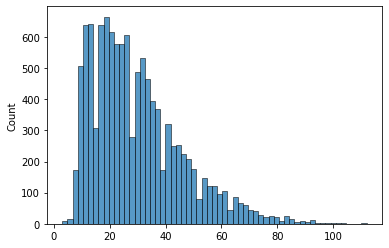

In [ ]:
import seaborn as sns
token_counts = []
for _, row in data.iterrows():
    token_count = len(tokenizer.encode(
        row["text"],
        max_length=512,
        truncation=True
    ))
    token_counts.append(token_count)
sns.histplot(token_counts)

In [ ]:
MAX_TOKEN_COUNT = 150

# Prepare dataset

In [ ]:
class EmoDataset(Dataset):
  def __init__(
    self,
    path,
    tokenizer: BertTokenizer,
    max_token_len: int = 100
  ):
    self.tokenizer = tokenizer
    self.data_column = "text"
    self.class_column = "class"
    self.data = pd.read_csv(path, sep="；", header=None, names=[self.data_column, self.class_column],
                            engine="python")
    
    self.max_token_len = max_token_len
  
  def __len__(self):
    return len(self.data)
  
  def __getitem__(self, index: int):
    data_row = self.data.iloc[index]
    text = data_row.text
    print(data_row)
    print(data_row["class"])
    labels = label2int[data_row["class"]]
    encoding = self.tokenizer.encode_plus(
      text,
      add_special_tokens=True,
      max_length=self.max_token_len,
      return_token_type_ids=False,
      padding="max_length",
      truncation=True,
      return_attention_mask=True,
      return_tensors='pt',
    )
    return dict(
      text=text,
      input_ids=encoding["input_ids"].flatten(),
      attention_mask=encoding["attention_mask"].flatten(),
      labels=torch.tensor(labels)
    )

In [ ]:
train_dataset = EmoDataset(
    train_path,
    tokenizer,
    max_token_len=100
)
sample_item = train_dataset[5]
sample_item.keys()

text     我一直感覺到情緒，只是沒有真正被它們打擾那麼強烈
class                         唔開心
Name: 5, dtype: object
唔開心


dict_keys(['text', 'input_ids', 'attention_mask', 'labels'])

In [ ]:
sample_item["labels"]
# sample_item["input_ids"].shape

tensor(0)

In [ ]:
bert_model = BertModel.from_pretrained("bert-base-chinese")
# model = AutoModelForMaskedLM.from_pretrained("bert-base-uncased")

Some weights of the model checkpoint at bert-base-chinese were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
sample_batch = next(iter(DataLoader(train_dataset, batch_size=16)))
sample_batch["input_ids"].shape, sample_batch["attention_mask"].shape

text     我感到暴躁和失望
class           嬲
Name: 0, dtype: object
嬲
text     我仍然覺得很討厭
class           嬲
Name: 1, dtype: object
嬲
text     我劃過天空 我開始感覺到貿易園里黑暗塔樓的邪惡 psi 氣味
class                                 嬲
Name: 2, dtype: object
嬲
text     我認為大多數遊戲玩家都知道希拉里·克林頓的立場，她強烈認為應該對暴力視頻遊戲對未成年人的影響...
class                                                    嬲
Name: 3, dtype: object
嬲
text     我在這裡確實提到了我打算寫一部浪漫喜劇，儘管我已經忘記了我對寫一部感到有些叛逆
class                                          嬲
Name: 4, dtype: object
嬲
text     我一直感覺到情緒，只是沒有真正被它們打擾那麼強烈
class                         唔開心
Name: 5, dtype: object
唔開心
text     我很快就睡著了，當親愛的主為我受了這麼多苦時，我覺得我受的苦是多麼少
class                                   唔開心
Name: 6, dtype: object
唔開心
text     我有一種感覺，這些可能會在我身上成長為我的最愛，很高興我撿到它們
class                                  開心
Name: 7, dtype: object
開心
text     我懷疑由於缺乏國家支持和對環境的參與，他感到無助
class                          擔心
Name: 8, dtype: object
擔心
text     我感到無助，有時甚至絕望，我似乎只是順著潮流和現狀走
class                            擔心
Name: 9, dtype: objec

(torch.Size([16, 100]), torch.Size([16, 100]))

In [ ]:
output = bert_model(sample_batch["input_ids"], sample_batch["attention_mask"])

In [ ]:
# 768 dimension comes from the BERT hidden size
output.last_hidden_state.shape, output.pooler_output.shape

(torch.Size([16, 100, 768]), torch.Size([16, 768]))

# Define custom classification model for fine-tuning

In [ ]:
#using Mish activation function 
#(from https://github.com/digantamisra98/Mish/blob/b5f006660ac0b4c46e2c6958ad0301d7f9c59651/Mish/Torch/mish.py)
@torch.jit.script
def mish(input):
    return input * torch.tanh(F.softplus(input))
  
class Mish(nn.Module):
    def forward(self, input):
        return mish(input)

In [ ]:
#define an EmoClassificationModel class to do the actual fine-tuning

class EmoClassificationModel(nn.Module):
    def __init__(self, base_model, n_classes, base_model_output_size=768, dropout=0.05):
        super().__init__()
        self.base_model = base_model
        
        self.classifier = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(base_model_output_size, base_model_output_size),
            Mish(),
            nn.Dropout(dropout),
            nn.Linear(base_model_output_size, n_classes)
        )
        
        for layer in self.classifier:
            if isinstance(layer, nn.Linear):
                layer.weight.data.normal_(mean=0.0, std=0.02)
                if layer.bias is not None:
                    layer.bias.data.zero_()

    def forward(self, input_ids, attention_mask, *args):

        hidden_states = self.base_model(input_ids, attention_mask=attention_mask)
        
        return self.classifier(hidden_states[0][:, 0, :])

# Prepare lightning module

In [ ]:
#use PyTorch Lightning for training.
#we use PyTorch Lighning for training. Lightning methods are defined here

class TrainingModule(pl.LightningModule):
    def __init__(self, hparams):
        super().__init__()
        self.model = EmoClassificationModel(BertModel.from_pretrained("bert-base-chinese"), len(labels)) #was "distilroberta-base"
        self.tokenizer = BertTokenizer.from_pretrained("bert-base-chinese")
        self.max_token_length = 128
        self.loss = nn.CrossEntropyLoss() #cross entropy loss since this is multi-class classification
        self.save_hyperparameters(hparams)
        self.loss_amount = 0.

    def step(self, batch, batch_idx, step_name="train"):
        input_ids = batch["input_ids"]
        attention_mask = batch["attention_mask"]
        labels = batch["labels"]
        loss = self.loss(self.forward(input_ids, attention_mask=attention_mask), labels)
        self.loss_amount = loss
        loss_key = f"{step_name}_loss"
        tensorboard_logs = {loss_key: loss}

        return { ("loss" if step_name == "train" else loss_key): loss, 'log': tensorboard_logs,
               "progress_bar": {loss_key: loss}}

    def forward(self, input_ids, attention_mask):
        return self.model(input_ids, attention_mask)

    def training_step(self, batch, batch_idx):
        return self.step(batch, "train")

    def training_end(self, outputs: List[dict]):
        self.loss_amount = torch.stack([x["train_loss"] for x in outputs]).mean()
    
    def validation_step(self, batch, batch_idx):
        return self.step(batch, "val")

    def validation_end(self, outputs: List[dict]):
        loss = torch.stack([x["val_loss"] for x in outputs]).mean()
        return {"val_loss": loss}
        
    def test_step(self, batch, batch_idx):
        return self.step(batch, "test")
    
    def train_dataloader(self):
        return self.create_data_loader(self.hparams.train_path, shuffle=True)

    def val_dataloader(self):
        return self.create_data_loader(self.hparams.val_path)

    def test_dataloader(self):
        return self.create_data_loader(self.hparams.test_path)
                
    def create_data_loader(self, ds_path: str, shuffle=False):
        return DataLoader(
                    EmoDataset(ds_path, self.tokenizer, self.max_token_length),
                    batch_size=self.hparams.batch_size,
                    shuffle=shuffle,
        )
        
    @lru_cache()
    def total_steps(self):
        return len(self.train_dataloader()) // self.hparams.accumulate_grad_batches * self.hparams.epochs

    def configure_optimizers(self):
        optimizer = AdamW(self.model.parameters(), lr=self.hparams.lr) #we use AdamW as this usually performs well
        lr_scheduler = get_linear_schedule_with_warmup(
                    optimizer,
                    num_warmup_steps=self.hparams.warmup_steps,
                    num_training_steps=self.total_steps(),
        )
        return [optimizer], [{"scheduler": lr_scheduler, "interval": "step"}]
   
    def save_model(self):
        torch.save(self.model.state_dict(), 'BERT_emotion_single_finetuned.pt')

# Hyperparameter Search (lr)

In [ ]:
import numpy as np
lrs = np.logspace(-1,-7,10)
losses = [0] * len(lrs)
for i in range(len(lrs)):
    hparams_tmp = Namespace(
    train_path=train_path,
    val_path=val_path,
    test_path=test_path,
    batch_size=16,
    warmup_steps=100,
    epochs=1,
    lr=lrs[i],
    accumulate_grad_batches=1
    )
    gc.collect()
    torch.cuda.empty_cache()
    module_tmp = TrainingModule(hparams_tmp)
    trainer = pl.Trainer(gpus=1, max_epochs=hparams_tmp.epochs, progress_bar_refresh_rate=50,
                    accumulate_grad_batches=hparams_tmp.accumulate_grad_batches)
    trainer.fit(module_tmp)
    losses[i] = module_tmp.loss_amount.cpu().detach().numpy()


Some weights of the model checkpoint at bert-base-chinese were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/connectors/callback_connector.py:97: LightningDeprecationWarning: Setting `Trainer(progres

Sanity Checking: 0it [00:00, ?it/s]

text     我從無助到強大
class         擔心
Name: 0, dtype: object
擔心
text     我真的需要發洩我的感情，我現在很生氣
class                     嬲
Name: 1, dtype: object
嬲
text     我覺得有點小氣
class          嬲
Name: 2, dtype: object
嬲
text     我終於進了浴室，但我無法做任何事情來讓自己感覺更好相信我，我什至嘗試嘔吐
class                                      開心
Name: 3, dtype: object
開心
text     我感覺就像一堆情感瓦礫
class            唔開心
Name: 4, dtype: object
唔開心
text     我真的厭倦了人們告訴我這不是故意的，因為這讓我覺得過去的一年都不重要或沒有任何意義
class                                           開心
Name: 5, dtype: object
開心
text     我為一個懷孕的朋友感到焦慮 我意識到我還沒有準備好認真考慮生另一個孩子
class                                     擔心
Name: 6, dtype: object
擔心
text     當我的伴侶想要親近時我感到不舒服
class                  擔心
Name: 7, dtype: object
擔心
text     我也注意到我開始感到非常沮喪
class               唔開心
Name: 8, dtype: object
唔開心
text     我並不特別覺得有必要為此找藉口，但我確實有點想知道這些樂隊被我的同齡人如此討厭，因為我認為他...
class                                                    嬲
Name: 9, dtype: object
嬲
text     我不喜歡線條像大提琴一樣圓潤的歌曲
class                   開心
Name: 10, dtype: ob

Training: 0it [00:00, ?it/s]

text     我也只是覺得我有很多愚蠢的差事，我不想騰出時間，但重要性會增加
class                                唔開心
Name: 165, dtype: object
唔開心
text     我只是在做一個快速的帖子，因為它太晚了，而且我因為懷孕三個月的孕吐而感覺不好
class                                        開心
Name: 8563, dtype: object
開心
text     我喜歡知道每當我覺得它們看起來有點臟時，我就可以把它們取下來清潔它們
class                                   唔開心
Name: 1281, dtype: object
唔開心
text     我很榮幸能獲得這個獎項，因為我覺得這是朝著這個令人難以置信的講故事傳統邁出的又一步
class                                           開心
Name: 6812, dtype: object
開心
text     當我沒有分心時，我無法阻止我獨自一人時的焦慮
class                       唔開心
Name: 4114, dtype: object
唔開心
text     我開始考慮重新寫博客，但我有點不知所措
class                     擔心
Name: 1370, dtype: object
擔心
text     走在外面我感覺更有信心了
class              開心
Name: 8641, dtype: object
開心
text     我走了，我只是覺得自己是城裡最受歡迎的女孩
class                       開心
Name: 4411, dtype: object
開心
text     反正我覺得你很反常我會毫不猶豫地阻止你
class                    唔開心
Name: 14286, dtype: object
唔開心
text     我覺得教室非常危險
class            嬲
Name: 5422, dtype: object
嬲
text     當我看到它弄

KeyError: ignored

In [ ]:
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_subplot(2, 1, 1)
line, = ax.plot(lrs, losses, color='b')
ax.set_xscale('log')
plt.xlabel("learning rates")
plt.ylabel("loss")
plt.show()


In [ ]:
pd.to_csv(train_dataset)

# Ori


In [ ]:
!pip uninstall transformers
!pip install transformers==4.18.0y

Found existing installation: transformers 4.20.1
Uninstalling transformers-4.20.1:
  Would remove:
    /usr/local/bin/transformers-cli
    /usr/local/lib/python3.7/dist-packages/transformers-4.20.1.dist-info/*
    /usr/local/lib/python3.7/dist-packages/transformers/*
Proceed (y/n)? y
  Successfully uninstalled transformers-4.20.1
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.0 MB 32.1 MB/s 
     |████████████████████████████████| 880 kB 60.5 MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.53-py3-none-any.whl size=895260 sha256=47e10a42df8f0131f5b8034cd04b905b52993b89028bb16ef88473e1c6c3db39
  Stored in directory: /root/.cache/pip/wheels/87/39/dd/a83eeef36d0bf98e7a4d1933a4ad2d660295a40613079bafc9
Successfully built sacremoses


In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
import torch
from transformers import TrainingArguments, Trainer
from transformers import BertTokenizerFast, BertForSequenceClassification
from transformers import EarlyStoppingCallback


# Read data
data = pd.read_csv("/content/gdrive/MyDrive/Individual Project/Model/LargeDataset/my_dataset.csv")

# Define pretrained tokenizer and model
# model_name = "/content/gdrive/MyDrive/Individual Project/Model/Final Model"
tokenizer = BertTokenizerFast.from_pretrained("bert-base-chinese")
model = BertForSequenceClassification.from_pretrained("bert-base-chinese", num_labels=4)

# ----- 1. Preprocess data -----#
# Preprocess data
X = list(data["content"])
y = list(data["label"])
# X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)

train_ratio = 0.75
validation_ratio = 0.15
test_ratio = 0.10

# train is now 75% of the entire data set
# the _junk suffix means that we drop that variable completely
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1 - train_ratio, random_state=0)

# test is now 10% of the initial data set
# validation is now 15% of the initial data set
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=test_ratio/(test_ratio + validation_ratio), random_state=0) 

X_train_tokenized = tokenizer(X_train, padding=True, truncation=True, max_length=512)
X_val_tokenized = tokenizer(X_val, padding=True, truncation=True, max_length=512)
X_test_tokenized = tokenizer(X_test, padding=True, truncation=True, max_length=512)


# Create torch dataset
class Dataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels=None):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        if self.labels:
            item["labels"] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.encodings["input_ids"])

train_dataset = Dataset(X_train_tokenized, y_train)
val_dataset = Dataset(X_val_tokenized, y_val)
test_dataset=Dataset(X_test_tokenized, y_test)

# ----- 2. Fine-tune pretrained model -----#
# Define Trainer parameters
def compute_metrics(p):
    pred, labels = p
    pred = np.argmax(pred, axis=1)

    accuracy = accuracy_score(y_true=labels, y_pred=pred)
    recall = recall_score(y_true=labels, y_pred=pred, average='micro')
    precision = precision_score(y_true=labels, y_pred=pred, average='micro')
    f1 = f1_score(y_true=labels, y_pred=pred, average='micro')

    return {"accuracy": accuracy, "precision": precision, "recall": recall, "f1": f1}

# Define Trainer
args = TrainingArguments(
    output_dir="/content/gdrive/MyDrive/Individual Project/Model",
    num_train_epochs=10,
    learning_rate =1e-5,
    adam_epsilon=1e-06, 
    per_device_train_batch_size=10,
    per_device_eval_batch_size=10,
    evaluation_strategy="epoch",
    save_strategy='epoch',
    disable_tqdm=False,
    eval_steps=500,
    logging_steps=500,
    log_level='error',
    save_total_limit = 2,
    load_best_model_at_end=True,
    metric_for_best_model='accuracy',
    overwrite_output_dir=False,
)
trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    # callbacks=[EarlyStoppingCallback(early_stopping_patience=3)],
    # callbacks=checkpoint_callback,
)

# Train pre-trained model
trainer.train()

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.453800,0.414961,0.869000,0.869000,0.869000,0.869000
2,0.355500,0.389060,0.877333,0.877333,0.877333,0.877333


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.453800,0.414961,0.869000,0.869000,0.869000,0.869000
2,0.355500,0.389060,0.877333,0.877333,0.877333,0.877333
3,0.273300,0.482273,0.869333,0.869333,0.869333,0.869333
4,0.235900,0.559721,0.873000,0.873000,0.873000,0.873000
5,0.197500,0.598345,0.875667,0.875667,0.875667,0.875667
6,0.171400,0.624162,0.882000,0.882000,0.882000,0.882000
7,0.118400,0.715196,0.877333,0.877333,0.877333,0.877333
8,0.085600,0.747963,0.878333,0.878333,0.878333,0.878333
9,0.075200,0.805825,0.875333,0.875333,0.875333,0.875333
10,0.050600,0.804090,0.878333,0.878333,0.878333,0.878333


TrainOutput(global_step=15000, training_loss=0.21559882532755534, metrics={'train_runtime': 3434.1413, 'train_samples_per_second': 43.679, 'train_steps_per_second': 4.368, 'total_flos': 8402232430800000.0, 'train_loss': 0.21559882532755534, 'epoch': 10.0})

In [ ]:
trainer.save_model("/content/gdrive/MyDrive/Individual Project/Model/LargeDataset/BERTLarge")

In [ ]:
trainer.train(resume_from_checkpoint='/content/gdrive/MyDrive/Individual Project/Model/checkpoint-148')

0it [00:00, ?it/s]

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
3,No log,0.678463,0.802721,0.802721,0.802721,0.802721


TrainOutput(global_step=222, training_loss=0.07656740068315386, metrics={'train_runtime': 16.0402, 'train_samples_per_second': 138.028, 'train_steps_per_second': 13.84, 'total_flos': 65990671003296.0, 'train_loss': 0.07656740068315386, 'epoch': 3.0})

In [ ]:
trainer.evaluate()

{'epoch': 20.0,
 'eval_accuracy': 0.2925170068027211,
 'eval_f1': 0.2925170068027211,
 'eval_loss': 1.4193344116210938,
 'eval_precision': 0.2925170068027211,
 'eval_recall': 0.2925170068027211,
 'eval_runtime': 0.4829,
 'eval_samples_per_second': 304.41,
 'eval_steps_per_second': 31.062}

In [ ]:
trainer.predict(test_dataset=test_dataset).metrics

{'test_accuracy': 0.21212121212121213,
 'test_f1': 0.21212121212121215,
 'test_loss': 1.4364556074142456,
 'test_precision': 0.21212121212121213,
 'test_recall': 0.21212121212121213,
 'test_runtime': 0.3287,
 'test_samples_per_second': 301.185,
 'test_steps_per_second': 30.423}

In [ ]:
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained("/content/gdrive/MyDrive/Individual Project/Model/Fine-tuned/best_bert-base-chinese", local_files_only=True)
trainer.model = model.cuda()
trainer.evaluate()

In [ ]:
# ----- 3. Predict -----#
# Load test data
# test_data = pd.read_csv("/content/gdrive/MyDrive/Individual Project/廣東話情感句子2.0.csv")
# X_test = list(test_data["content"])
# X_test_tokenized = tokenizer(X_test, padding=True, truncation=True, max_length=512)

# Create torch dataset
test_dataset = test_dataset

# Load trained model
model_path = "/content/gdrive/MyDrive/Individual Project/Model/LargeDataset/BERTLarge"
model = BertForSequenceClassification.from_pretrained(model_path)

# Define test trainer
test_trainer = Trainer(model)

# Make prediction
raw_pred, _, _ = test_trainer.predict(test_dataset)

# Preprocess raw predictions
y_pred = np.argmax(raw_pred, axis=1)

***** Running Prediction *****
  Num examples = 2000
  Batch size = 8


In [ ]:
from sklearn import metrics

In [ ]:
print(metrics.classification_report(y_test, y_pred, digits=4))

              precision    recall  f1-score   support

           0     0.8648    0.8717    0.8683       499
           1     0.9147    0.8298    0.8702       517
           2     0.8618    0.9158    0.8880       463
           3     0.8937    0.9194    0.9063       521

    accuracy                         0.8835      2000
   macro avg     0.8837    0.8842    0.8832      2000
weighted avg     0.8845    0.8835    0.8832      2000

